# 大作业：目标检测


| 姓名 | 学号 |
| :--: | :--: |
| 洪耀森 | 1120213563 |


### Codalab账号：hongyaosen
### result截图：

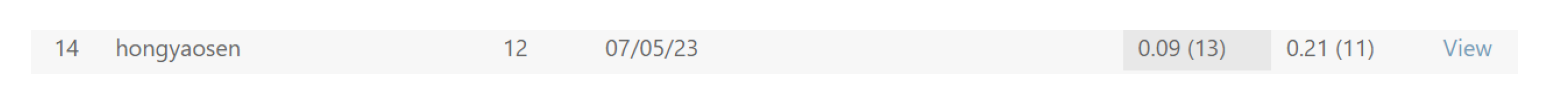

In [11]:
# from matplotlib import pyplot as plt
# from PIL import Image
# RESULT_IMAGE_PATH='./image.png'
# img = Image.open(RESULT_IMAGE_PATH)
# plt.figure(dpi=300)
# plt.axis('off')
# plt.imshow(img)

In [1]:
import torch
import torch.nn as nn
import json, os
import pandas as pd
import numpy as np
import cv2
from PIL import Image
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

### 数据配置：

In [2]:
LABEL_PATH="./labels/"
TRAIN_IMAGE_PATH="./dl_detection/train/"
TEST_IMAGE_PATH="./dl_detection/test/"
CATEGORIE_NUM=21
GRID_NUM=7
NUM_BBOX=2
DATA_DIR = './dl_detection'
train_labels=[]
IMAGE_SIZE=448
TRAIN_NUM=33353 #训练时应设置为33353，测试时可适当调小

epochs = 20
batchsize = 32
lr = 0.00005

### 数据预处理：

In [3]:
#图片信息提取
anno = open(os.path.join(DATA_DIR, 'annotations/train.json'), 'rt', encoding='UTF-8')
anno = json.load(anno)

In [4]:
#获取所有的分类
categories_id = [i for i in range(21)]
id_count = [0] * 21
categories_name = [categorie['name'] for categorie in anno['categories']]

for elem in anno['annotations']:
    id_count[elem['category_id']] += 1
    

In [5]:
#初始数据为左上，宽高的形式
#进行归一化处理：
def convert(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    w = box[2]
    h = box[3] 
    x = box[0]+w//2
    y = box[1]+h//2

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return (x, y, w, h)

#需要图片的宽高，id
#需要bbox的image_id 坐标 category_id
def convert_annotation(image_id):

    path = LABEL_PATH+'{}.txt'.format(image_id)
    out_file = open(path, 'w')
    image_w=0.0
    image_h=0.0
    for elem in anno['images']:
        if elem['id'] == image_id:
            image_w=elem['width']
            image_h=elem['height']
    #扫一遍，将图片对应的bbox加入
    for elem in anno['annotations']:
        if elem['image_id'] == image_id:
            bbox=convert((image_w, image_h), elem['bbox'])
            out_file.write(str(elem['category_id']) + " " + " ".join([str(a) for a in bbox]) + '\n')

def make_label_txt():
    for i in range (33353+1):
        convert_annotation(i)
    
#下面是把标签放到内存里的代码，因为每次启动都要处理五分钟左右，已经弃置了
# def convert_annotation(image_id):
#     image_w=0.0
#     image_h=0.0
#     for elem in anno['images']:
#         if elem['id'] == image_id:
#             image_w=elem['width']
#             image_h=elem['height']
#     #扫一遍，将图片对应的bbox加入
#     for elem in anno['annotations']:
#         if elem['image_id'] == image_id:
#             bbox=convert((image_w, image_h), elem['bbox'])
#             imfo=[]
#             imfo.append(elem['category_id'])
#             for each in bbox:
#                 imfo.append(each)
#             train_labels[image_id].append(imfo)
# def make_label():
#     for i in range (33353+1):
#         train_labels.append([])
#     for i in range (33353+1):
#         convert_annotation(i)
#大概要处理五分钟
# make_label()


In [6]:
#调用下面的代码把label写成txt，路径为./labels/img_id.txt
#初次运行去掉make_label_txt()代码的注释
# make_label_txt()

640 427


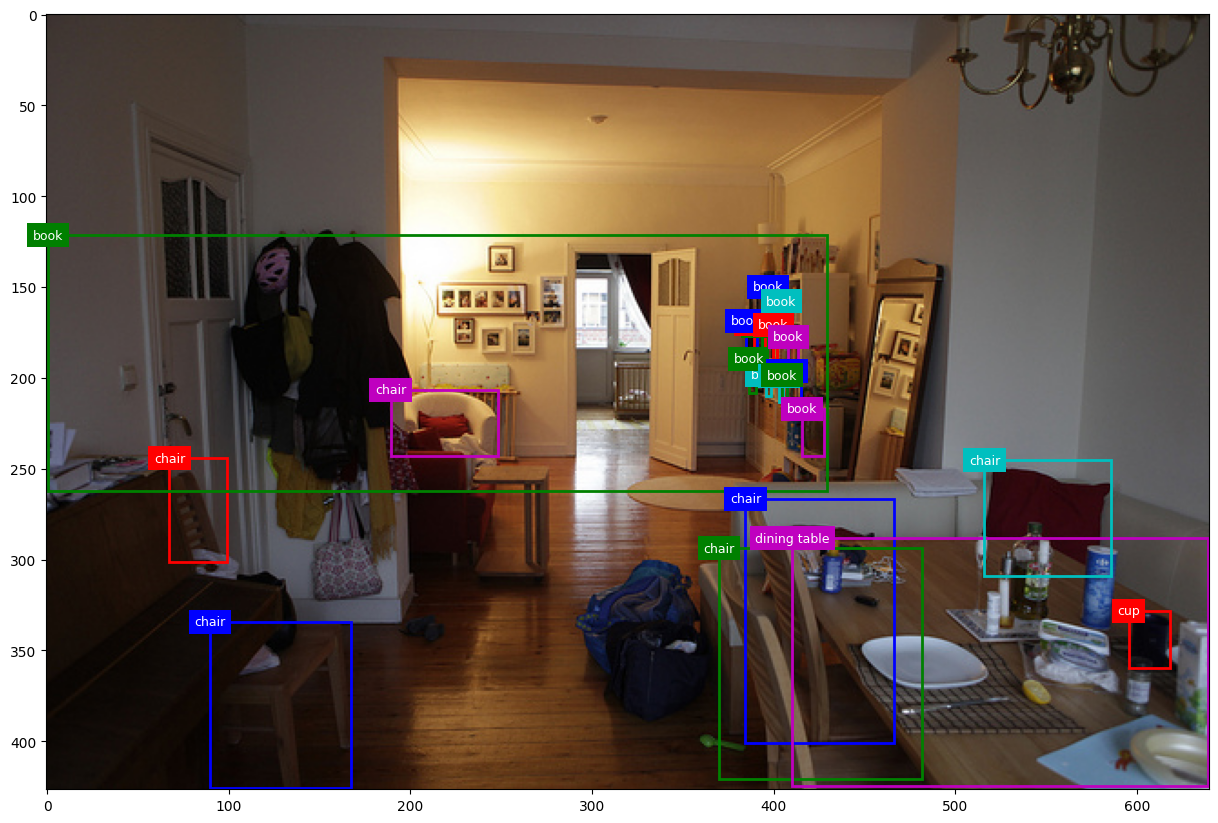

In [7]:
#打印测试
def show_labels_img(img_id):
    img = Image.open(TRAIN_IMAGE_PATH + '%07d.jpg'%img_id)
    w, h = img.size
    print(w,h)
    show_img_bbox = []
    show_img_label = []
    img_id_str=str(img_id)
    with open(LABEL_PATH+img_id_str+".txt",'r') as flabel:
        for label in flabel:
            label = label.split(' ')
            label = [float(x.strip()) for x in label]
            show_img_label.append(categories_name[int(label[0])])
            show_img_bbox.append([(label[1]-label[3]/2)*w,(label[2]-label[4]/2)*h,label[3]*w,label[4]*h])

            # print(label[1]*w,label[2]*h,label[3]*w,label[4]*h)
    colors = ['b', 'g', 'r', 'm', 'c']
    text_color = 'w'
    plt.figure(figsize=(15,15))
    fig = plt.imshow(img)
    for idx, bbox in enumerate(show_img_bbox):
        color = colors[idx % len(colors)]
        rect = plt.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2], height=bbox[3], fill=False, edgecolor=color, linewidth=2)
        fig.axes.add_patch(rect)
        fig.axes.text(bbox[0], bbox[1], show_img_label[idx], va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))
show_labels_img(505)


### 装载数据集

In [5]:
#这里的转换存在一个问题：如果在同一个网格中存在两个物体，最后只会有一个被保存
#将bbox的（cls_num,x,y,w,h）转化成(GRID_NUM,GRID_NUM,5*B+cls_num)，方便计算Loss
#这里编码按照数组的习惯来了，采用（7*7）=（gridy，gridx）的形式
def convert_bboxtolabels(bbox):
    gridsize = 1.0/GRID_NUM
    #共21种分类
    labels = np.zeros((GRID_NUM,GRID_NUM,5*NUM_BBOX+CATEGORIE_NUM))
    for i in range(len(bbox)//5):
        # 计算当前bbox中心落在哪个网格（gridx，gridy）
        gridx = int(bbox[i*5+1] // gridsize)  
        gridy = int(bbox[i*5+2] // gridsize)  
        #计算 bbox中心点的相对位置
        gridpx = bbox[i * 5 + 1] / gridsize - gridx
        gridpy = bbox[i * 5 + 2] / gridsize - gridy
        
        # 将第gridy行，gridx列的网格设置为负责当前ground truth的预测，置信度和对应类别概率均置为1
        labels[gridy, gridx, 0:5] = np.array([gridpx, gridpy, bbox[i * 5 + 3], bbox[i * 5 + 4], 1])
        labels[gridy, gridx, 5:10] = np.array([gridpx, gridpy, bbox[i * 5 + 3], bbox[i * 5 + 4], 1])
        labels[gridy, gridx, 10+int(bbox[i*5])] = 1
    return labels


In [6]:
#定义我的Dataset
class MYDataset(Dataset):
    def __init__(self,is_train=True):
        self.is_train=is_train
        if is_train:
            self.file_id=list(range(TRAIN_NUM+1))
        else :
            self.file_id=list(range(33353+1,49715+1))
            
        

    # 返回数据集的样本数量
    def __len__(self):
        return len(self.file_id)

    # 加载和预处理图像和标注
    def __getitem__(self, item):
        if self.is_train:
            img = cv2.imread(TRAIN_IMAGE_PATH + '%07d.jpg'%self.file_id[item])
            h,w = img.shape[0:2]
            #图片大小不一致，需要添加padding转化成正方形，然后缩放成448*448的大小
            #bbox也需一并调整
            padw, padh = 0, 0
            if h>w:
                padw = (h - w) // 2
                img = np.pad(img,((0,0),(padw,padw),(0,0)),'constant',constant_values=0)
            
            elif w>h:
                padh = (w - h) // 2
                img = np.pad(img,((padh,padh),(0,0),(0,0)), 'constant', constant_values=0)

            img = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE))
        
            # 读取图像对应的bbox信息，并根据padding作出相应调整
            file_id_str=str(self.file_id[item]) 
            with open(LABEL_PATH+file_id_str+".txt") as f:
                bbox = f.read().split('\n')
                bbox = [x.split() for x in bbox]
                bbox = [float(x) for y in bbox for x in y]
        
            for i in range(len(bbox)//5):
                if padw != 0:
                    bbox[i * 5 + 1] = (bbox[i * 5 + 1] * w + padw) / h
                    bbox[i * 5 + 3] = (bbox[i * 5 + 3] * w) / h
                elif padh != 0:
                    bbox[i * 5 + 2] = (bbox[i * 5 + 2] * h + padh) / w
                    bbox[i * 5 + 4] = (bbox[i * 5 + 4] * h) / w
            #打印图片看看对不对
            # cv2.imshow('Image',img)
            # cv2.waitKey(0)
            labels = convert_bboxtolabels(bbox)
            labels = ToTensor()(labels)
            img = transforms.ToTensor()(img)
            img = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])(img)
            return img, labels

        else:
            img = cv2.imread(TEST_IMAGE_PATH + '%07d.jpg'%self.file_id[item])
            h,w = img.shape[0:2]
            #图片大小不一致，需要添加padding转化成正方形，然后缩放成448*448的大小
            #bbox也需一并调整
            padw, padh = 0, 0
            if h>w:
                padw = (h - w) // 2
                img = np.pad(img,((0,0),(padw,padw),(0,0)),'constant',constant_values=0)
            
            elif w>h:
                padh = (w - h) // 2
                img = np.pad(img,((padh,padh),(0,0),(0,0)), 'constant', constant_values=0)
            img = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE))

            img = transforms.ToTensor()(img)
            img = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])(img)
        #顺便返回图片的宽高，不然解码的时候还要再取一次（要计算padding），很麻烦
        return img, [self.file_id[item],w,h]

### 定义损失函数：

In [8]:
#计算iou交并比
def calculate_iou(bbox1,bbox2):
    #传入坐标为左上右下形式
    #获取交集
    i_bbox = [0., 0., 0., 0.]
    if bbox1[2]<bbox2[0] or bbox1[0]>bbox2[2] or bbox1[3]<bbox2[1] or bbox1[1]>bbox2[3]:
        pass
    else:
        i_bbox[0] = max(bbox1[0],bbox2[0])
        i_bbox[1] = max(bbox1[1],bbox2[1])
        i_bbox[2] = min(bbox1[2],bbox2[2])
        i_bbox[3] = min(bbox1[3],bbox2[3])

    area1 = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])  # bbox1面积
    area2 = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])  # bbox2面积
    i_area = (i_bbox[2] - i_bbox[0]) * (i_bbox[3] - i_bbox[1])  # 交集面积
    # print(bbox1,bbox2)
    # print(intersect_bbox)
    # input()

    if i_area>0:
        return i_area / (area1 + area2 - i_area)  # 计算iou
    else:
        return 0


In [11]:
import torch
class MY_YOLOv1_Loss(nn.Module):
    def __init__(self,lambda_coord=7, lambda_noobj=0.7):
        super(MY_YOLOv1_Loss,self).__init__()
        self.lambda_coord = lambda_coord  # 坐标损失的权重
        self.lambda_noobj = lambda_noobj  # 无物体损失的权重
        self.mse_loss = nn.MSELoss(reduction='sum')  # 平方误差损失

    def forward(self, predictions, labels):
        #网络输出（batchsize，31,7,7）
        #样本标签为（batchsize，31,7,7）
        #先转换一下格式，比较好算
        predictions=predictions.permute((0,2,3,1))
        labels=labels.permute((0,2,3,1))
        N=5*NUM_BBOX+CATEGORIE_NUM
        # 计算有物体和无物体的掩码
        obj_mask = labels[:, :, :, 4] > 0
        obj_mask = obj_mask.unsqueeze(3)
        noobj_mask = labels[:, :, :, 4] == 0
        noobj_mask = noobj_mask.unsqueeze(3)

        # 将预测结果分割为不同部分，并根据有无物体做掩码处理
        coord_pred = predictions[obj_mask.expand_as(labels)].view(-1, N)
        bbox_pred = coord_pred[:, :5*NUM_BBOX].contiguous().view(-1, 5)
        class_pred = coord_pred[:, 5*NUM_BBOX:] 
        # 将标签也分割为不同部分
        coord_target = labels[obj_mask.expand_as(labels)].view(-1, N)
        bbox_target = coord_target[:, :5*NUM_BBOX].contiguous().view(-1, 5)
        class_target = coord_target[:, 5*NUM_BBOX:]

        #无物体的预测
        noobj_pred = predictions[noobj_mask.expand_as(labels)].view(-1, N)
        noobj_target = labels[noobj_mask.expand_as(labels)].view(-1, N)

        noobj_conf_mask = torch.zeros(noobj_pred.size()).bool()
        
        #计算无物体置信度的损失
        for b in range(NUM_BBOX):
            noobj_conf_mask[:, 4 + b*5] = 1
        noobj_pred_conf = noobj_pred[noobj_conf_mask]
        noobj_target_conf = noobj_target[noobj_conf_mask]
        loss_noobj = self.mse_loss(noobj_pred_conf, noobj_target_conf)
        
        coord_response_mask = torch.zeros(bbox_target.size()).bool()
        coord_not_response_mask = torch.ones(bbox_target.size()).bool()
        bbox_target_iou = torch.zeros(bbox_target.size()).cuda()

        for i in range(0, bbox_target.size(0), NUM_BBOX):
            #每次取得同一网格对应的两个预测框，形状为（2,5）
            pred = bbox_pred[i:i+NUM_BBOX] 
            pred_xyxy = torch.FloatTensor(pred.size()) 
            #因为进行了归一化处理，因此需要重新缩放来计算正确的交并比
            #因为预测和标签对应的网格是同一个，算交并比就没必要就算绝对的坐标位置了
            #左上
            pred_xyxy[:,  :2] = pred[:, :2]/GRID_NUM-pred[:, 2:4]/2.0
            #右下
            pred_xyxy[:, 2:4] = pred[:, :2]/GRID_NUM+pred[:, 2:4]/2.0
            #拿到标签对应的bbox框，也可以拿bbox_target[i+1] ，两个框都是一样的，随便拿一个
            target = bbox_target[i] 
            target = bbox_target[i].view(-1, 5)
            target_xyxy = torch.FloatTensor(target.size())
            #与上面相同，计算正确的左上右下坐标
            target_xyxy[:,  :2] = target[:, :2]/GRID_NUM-target[:, 2:4]/2.0
            target_xyxy[:, 2:4] = target[:, :2]/GRID_NUM+target[:, 2:4]/2.0
            #分别计算交并比
            iou1 = calculate_iou(pred_xyxy[0, :4].squeeze(), target_xyxy[:, :4].squeeze())
            iou2 = calculate_iou(pred_xyxy[1, :4].squeeze(), target_xyxy[:, :4].squeeze())
            if iou1>iou2:
                max_iou, max_index = iou1,0
            else:
                max_iou, max_index = iou2,1

            #只对负责预测物体的预测框计算损失
            coord_response_mask[i+max_index] = 1
            coord_not_response_mask[i+max_index] = 0
            
            bbox_target_iou[i+max_index, torch.LongTensor([4])] = max_iou

        bbox_pred_response = bbox_pred[coord_response_mask].view(-1, 5)
        bbox_target_response = bbox_target[coord_response_mask].view(-1, 5)
        target_iou = bbox_target_iou[coord_response_mask].view(-1, 5)
        #就散xy坐标损失
        loss_xy = self.mse_loss(bbox_pred_response[:, :2], bbox_target_response[:, :2])
        #计算wh损失，为了平衡对小目标和大目标的预测精度，需要开根
        loss_wh = self.mse_loss(torch.sqrt(bbox_pred_response[:, 2:4]), torch.sqrt(bbox_target_response[:, 2:4]))
        #置信度损失
        loss_obj = self.mse_loss(bbox_pred_response[:, 4], target_iou[:, 4])
        #计算类别损失
        loss_class = self.mse_loss(class_pred, class_target)
        #总损失
        loss = self.lambda_coord * (loss_xy + loss_wh) + loss_obj + self.lambda_noobj * loss_noobj + loss_class
        # print('Lossxy',loss_xy)
        # print('Losswh',loss_wh)
        # print('Losscls',loss_class)
        # print('Lossconf',loss_obj)
        
        return loss/batchsize


### 搭建模型：

In [12]:
class YOLOv1_resnet(nn.Module):
    def __init__(self):
        super(YOLOv1_resnet,self).__init__()
        #调用torchvision里的resnet模型作为特征提取网络
        resnet = torchvision.models.resnet18(pretrained=True)
        #冻结参数
        # for param in resnet.parameters():
        #     param.requires_grad = False

        #抛弃掉resnet的最后两层
        self.features = nn.Sequential(*list(resnet.children())[:-2])# 去除resnet的最后两层
        
        # 卷积层
        self.Conv_layers = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace=True)
        )
        # 全连接层
        self.Conn_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(GRID_NUM*GRID_NUM * 1024, 4096),
            nn.Linear(4096,GRID_NUM*GRID_NUM*(5*NUM_BBOX+CATEGORIE_NUM)),
            nn.Sigmoid() 
        )

    def forward(self, x):
        x=self.features(x)
        x=self.Conv_layers(x)
        x=self.Conn_layers(x)
        x=x.view(-1, (5*NUM_BBOX+CATEGORIE_NUM), GRID_NUM, GRID_NUM)
        return x


### 开始训练：

In [13]:
model=YOLOv1_resnet()
train_data=MYDataset()
test_data=MYDataset(is_train=False)
criterion=MY_YOLOv1_Loss()
optimizer=torch.optim.Adam(model.parameters(),lr,weight_decay=0.0001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

e:\anaconda\envs\PyTorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\anaconda\envs\PyTorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
# predictions=train_data[0][1]

# predictions=predictions.permute(1,2,0)
# lab_p="./test1234.txt"
# with open(lab_p,"w") as f:
#     for i in range (7):
#         for j in range(7):
#             f.write('\n'+"X"+str(i)+" Y"+str(j)+":")
#             for each in predictions[i][j]:
#                 f.write(" ")
#                 f.write(str(each.item()))
# predictions=predictions.unsqueeze(0)
# print(predictions.shape)
# pred_boxes1 = predictions[:, :4, :, :]
# pred_boxes2 = predictions[:, 5:9, :, :]
# pred_boxes=torch.cat((pred_boxes1,pred_boxes2),dim=1)
# print(pred_boxes.shape)
# pred_confidence = torch.cat((predictions[:, 4, :, :].unsqueeze(1),predictions[:, 9, :, :].unsqueeze(1)),dim=1)
# print(pred_confidence.shape)
# pred_class = predictions[:, 10:, :, :]
# print(pred_class.shape)


In [15]:
#网络训练
def train(model,train_data,criterion,optimizer,device):
    train_dataloader = DataLoader(train_data,batch_size=batchsize,shuffle=True)
    model.to(device)
    criterion.to(device)
    #开始训练
    train_loss_list=[]
    for epoch in range(epochs):
        model.train()
        yl = torch.Tensor([0]).to(device)
        for i,(inputs,labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.float().to(device)
            pred = model(inputs)
            loss = criterion(pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            yl = yl + loss.item()
        print("Epoch %d/%d| Loss: %.2f"%(epoch+1,epochs,yl))
        train_loss_list.append(yl)
        #保存模型
        if (epoch+1)%10==0:
            torch.save(model,"./models/YOLOv1_epoch"+str(epoch+1)+".pt")
            
    return train_loss_list


In [16]:
#开始训练！
loss_list=train(model,train_data,criterion,optimizer,device)

Epoch 1/20| Loss: 1156.93
Epoch 2/20| Loss: 826.81
Epoch 3/20| Loss: 656.24
Epoch 4/20| Loss: 536.46
Epoch 5/20| Loss: 439.97
Epoch 6/20| Loss: 375.29
Epoch 7/20| Loss: 328.94
Epoch 8/20| Loss: 292.90
Epoch 9/20| Loss: 267.04
Epoch 10/20| Loss: 252.09
Epoch 11/20| Loss: 241.72
Epoch 12/20| Loss: 227.93
Epoch 13/20| Loss: 218.97
Epoch 14/20| Loss: 213.21
Epoch 15/20| Loss: 206.98
Epoch 16/20| Loss: 202.56
Epoch 17/20| Loss: 198.30
Epoch 18/20| Loss: 195.09
Epoch 19/20| Loss: 192.45
Epoch 20/20| Loss: 189.36


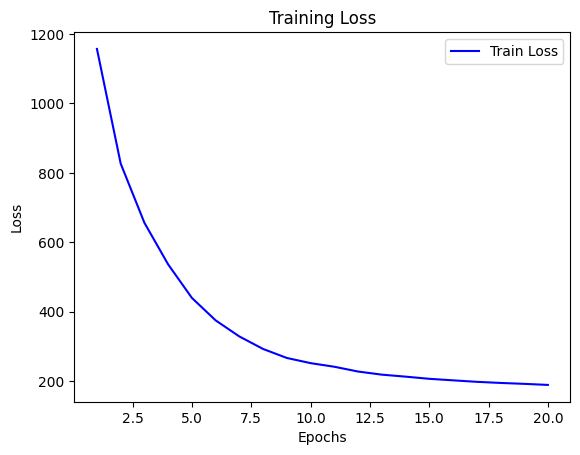

In [20]:
epochs = range(1, len(loss_list) + 1)
value_loss_list=[]
for each in loss_list:
    value_loss_list.append(each.tolist())
# 绘制损失值变化曲线
plt.plot(epochs, value_loss_list, 'b', label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 结果预测：

In [21]:
#清理置信度较低和消除重叠的边界框，同时将数据从（7*7*2，26）转换成（7*7,6）的格式
def NMS(bbox, conf_thresh=0.3, iou_thresh=0.5):
    n = bbox.size()[0]
    # 类别预测的概率
    bbox_prob = bbox[:,5:].clone()  
    # 将置信度拓展为和类别预测形状相同
    bbox_conf = bbox[:, 4].clone().unsqueeze(1).expand_as(bbox_prob)  
    # 置信度*类别条件概率，包含是否有物体及是什么物体的两种信息
    bbox_clsconf = bbox_conf*bbox_prob  
    # 将低于阈值的bbox忽略
    bbox_clsconf[bbox_clsconf<=conf_thresh] = 0 
    for c in range(CATEGORIE_NUM):
        #根据每个网格（每个网格对应两个bbox）的概率进行排序
        rank = torch.sort(bbox_clsconf[:,c],descending=True).indices
        #用循环把每个边界框都对比一下
        for i in range(GRID_NUM*GRID_NUM*NUM_BBOX):
            if bbox_clsconf[rank[i],c]!=0:
                for j in range(i+1,GRID_NUM*GRID_NUM*NUM_BBOX):
                    if bbox_clsconf[rank[j],c]!=0:
                        iou = calculate_iou(bbox[rank[i],0:4],bbox[rank[j],0:4])
                        # 根据iou进行非极大值抑制抑制
                        if iou > iou_thresh:  
                            bbox_clsconf[rank[j],c] = 0
    #找到21个类别中最大的，排除置信度为0的
    max_clsconf, _ = torch.max(bbox_clsconf, dim=1)
    mask=max_clsconf>0
    bbox = bbox[mask]  
    bbox_clsconf = bbox_clsconf[mask]
    res = torch.ones((bbox.size()[0],6))
    res[:,0:4] = bbox[:,0:4]  # 储存最后的bbox坐标信息
    res[:,5] = torch.argmax(bbox[:,5:],dim=1).int()  # 储存bbox对应的类别信息
    res[:,4] = torch.max(bbox_clsconf,dim=1).values  # 储存bbox对应的置信度和类别
    return res

In [22]:
def convert_labels_to_bbox(lable,w,h):
    bbox = torch.zeros((GRID_NUM*GRID_NUM*NUM_BBOX,5+CATEGORIE_NUM))
    #bbox传入数据为（7*7*31），31前10个数据格式为（gridpx，gridpy，w，h，conf），后21个为类别
    #bbox数据格式先转换为(n,26)
    #即从(7,7,31)转换成(7*7*2,26)的形式
    #再经过NMS算法，变成标准的输出格式（x1，y1，x2，y2，conf，cls）
    for i in range(GRID_NUM):  
        for j in range(GRID_NUM):  
            #先转化为左上右下格式
            #偶数，对应一个检测框
            bbox[2*(i*GRID_NUM+j),0:4] = torch.Tensor([(lable[i, j, 0] + j) /GRID_NUM  - lable[i, j, 2] / 2,
                                                (lable[i, j, 1] + i) / GRID_NUM - lable[i, j, 3] / 2,
                                                (lable[i, j, 0] + j) / GRID_NUM + lable[i, j, 2] / 2,
                                                (lable[i, j, 1] + i) / GRID_NUM + lable[i, j, 3] / 2])
            bbox[2*(i*GRID_NUM+j),4] = lable[i,j,4]
            bbox[2*(i*GRID_NUM+j),5:] = lable[i,j,10:]
            #奇数，对应另一个检测框
            bbox[2*(i*GRID_NUM+j)+1,0:4] = torch.Tensor([(lable[i, j, 5] + j) / GRID_NUM - lable[i, j, 7] / 2,
                                                (lable[i, j, 6] + i) / GRID_NUM - lable[i, j, 8] / 2,
                                                (lable[i, j, 5] + j) / GRID_NUM + lable[i, j, 7] / 2,
                                                (lable[i, j, 6] + i) / GRID_NUM + lable[i, j, 8] / 2])
            bbox[2*(i*GRID_NUM+j)+1,4] = lable[i,j,9]
            bbox[2*(i*GRID_NUM+j)+1,5:] = lable[i,j,10:]
    
    bboxes=NMS(bbox)
    #计算绝对坐标
    padw,padh=0,0
    if w>h:
        padh=(w-h)//2
        bboxes[:,1]=bboxes[:,1]*w-padh
        bboxes[:,3]=bboxes[:,3]*w-padh
        bboxes[:,0]=bboxes[:,0]*w
        bboxes[:,2]=bboxes[:,2]*w
    elif h>w:
        padw=(h-w)//2
        bboxes[:,0]=bboxes[:,0]*h-padw
        bboxes[:,2]=bboxes[:,2]*h-padw
        bboxes[:,1]=bboxes[:,1]*h
        bboxes[:,3]=bboxes[:,3]*h
    return bboxes

In [10]:
import csv

# RESULT_PATH="./result/"
RESULT_PATH='./'
def wirteresult(bboxes,image_id):
    with open(RESULT_PATH+'test.csv', "a",newline='') as file:
        writer = csv.writer(file,quoting=csv.QUOTE_NONE,escapechar=',')
        row=[image_id.item()]
        bbox_str=''
        if(torch.numel(bboxes) == 0):
            bbox_str+='{0 0 0 0 0 19}'
        else:
            for bbox in bboxes:
                bbox_str+=f'{{{bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]} {bbox[4]} {int(bbox[5])}}}'
        row.append(bbox_str)
        writer.writerow(row)

In [24]:
#进行预测
def predict(model,test_data,criterion,optimizer,device):
    #预测时，batch_size调整为1
    test_dataloader = DataLoader(test_data,batch_size=1,shuffle=False)
    model.to(device)
    model.eval()
    with open(RESULT_PATH+'test.csv', "a",newline='') as file:
        writer = csv.writer(file,quoting=csv.QUOTE_NONE)
        f_header=['image_id','predictions']
        writer.writerow(f_header)
    yl = torch.Tensor([0]).to(device)
    
    for i,(inputs,img_info) in enumerate(test_dataloader):
        img_id,w,h=img_info
        inputs = inputs.to(device)
        
        pred = model(inputs)
        pred = pred.squeeze(dim=0)      #将第一维度压缩，成为(31,7,7)
        pred = pred.permute((1,2,0))    #转化为(7,7,31)

        bbox = convert_labels_to_bbox(pred,w,h)
        wirteresult(bbox,img_id)
        
# model = torch.load("./models/YOLOv1_epoch20.pt")
predict(model,test_data,criterion,optimizer,device)   

503 640


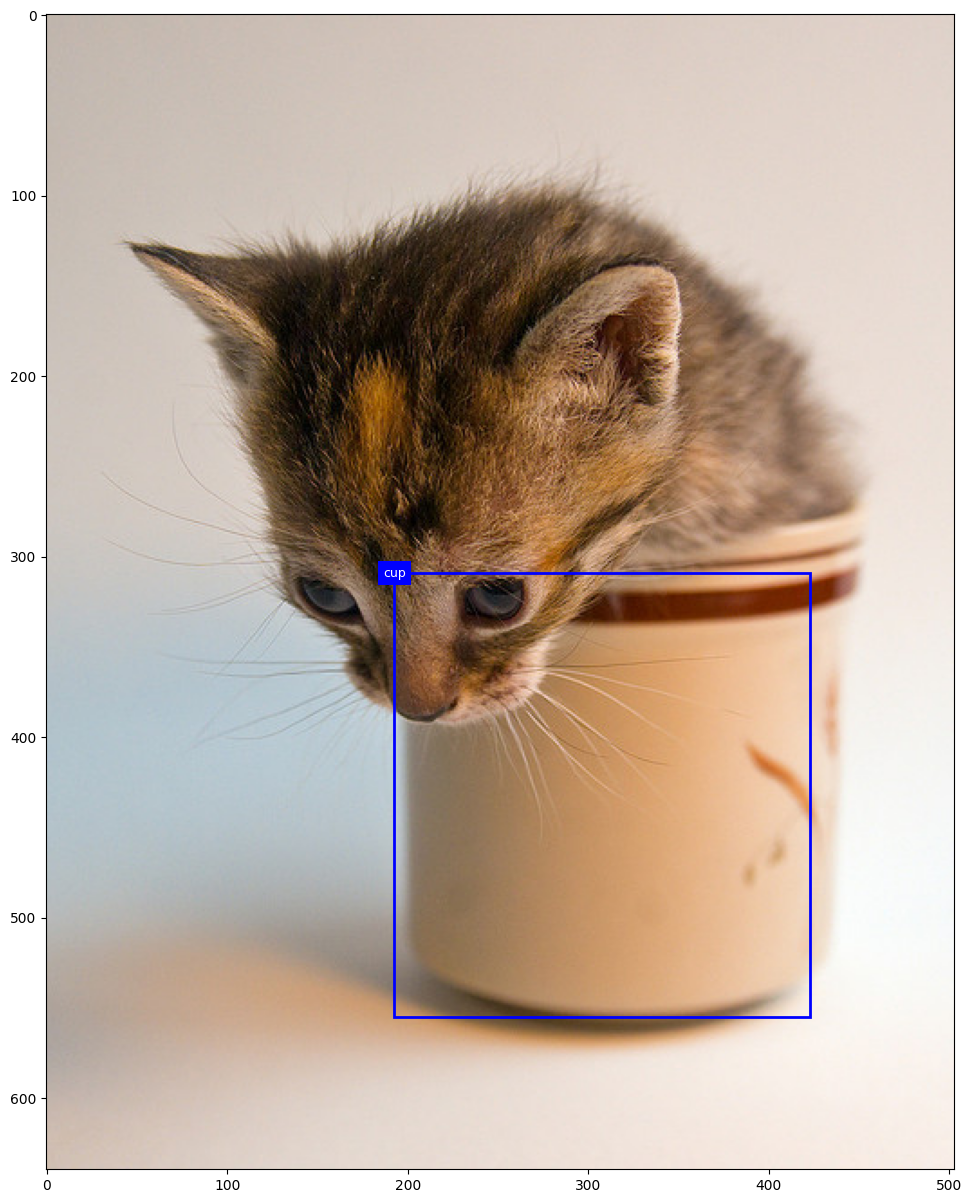

In [13]:
#看看效果
def show_result_img(img_id):
    img = Image.open(TEST_IMAGE_PATH + '%07d.jpg'%img_id)
    w, h = img.size
    print(w,h)
    show_img_bbox = []
    show_img_label = []
    img_id_str=str(img_id)
    with open(RESULT_PATH+"test.csv",'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            if (int(row['image_id'])==img_id):
                bboxes= row['predictions'].strip("{}")
                bboxes = bboxes.replace("}{", " ")
                bboxes=bboxes.split()
                bboxes = [float(x) for x in bboxes]
                for i in range(len(bboxes)//6):
                    bx=bboxes[i*6+0]
                    by=bboxes[i*6+1]
                    bw=bboxes[i*6+2]-bboxes[i*6+0]
                    bh=bboxes[i*6+3]-bboxes[i*6+1]
                    show_img_bbox.append([bx,by,bw,bh])
                    show_img_label.append(categories_name[int(bboxes[i*6+5])])
            
            # print(label[1]*w,label[2]*h,label[3]*w,label[4]*h)
    colors = ['b', 'g', 'r', 'm', 'c']
    text_color = 'w'
    plt.figure(figsize=(15,15))
    fig = plt.imshow(img)
    for idx, bbox in enumerate(show_img_bbox):
        color = colors[idx % len(colors)]
        rect = plt.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2], height=bbox[3], fill=False, edgecolor=color, linewidth=2)
        fig.axes.add_patch(rect)
        fig.axes.text(bbox[0], bbox[1], show_img_label[idx], va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))
        
show_result_img(33403)

### 思路与心得：
    在本次目标检测任务中，我主要参考了YOLOv1目标检测模型。在该任务中，我体验了从数据预处理，定义数据集，建立模型，定义损失函数，结果预测一系列过程，对深度学习有了更深入的了解。在实践过程中，我也遇到了一系列的问题，比如：在进行数据预处理时，因为bbox的y坐标运算写错，导致后面训练出来的模型算出来一堆负数。在这之后，我也养成了每写一个小模块都进行验证的习惯。不过，验证还是比较粗糙的，在大多数情况下，基本还是秉承着“只要不报错，能跑就算胜利”的准则。

    第一次训练跑了大概三四个小时，但模型训练出的效果特别差。当设置conf_thresh=0.1时（即置信度小于0.1时就抛弃预测框），几乎预测不出任何物体。既然发现了问题，接下来就是要解决问题。但说实话，根本不知道问题出在哪里。一开始的想法是先调一下学习率，优化器啥的，但都没有起到作用。这就有点恐怖了，一整个项目流程，数据编码解码，数据集定义，定义损失函数，任何一个环节出问题都会导致训练失败，代码千百行，一行行查过去也不一定能发现问题。。。于是，我开始一块一块地重写代码，每写一块都用一个较小的训练集跑几轮训练模型进行验证，最后发现是损失函数中写掩码的时候，把一处应该置为1的地方写成0了，导致模型往奇怪的方向进行收敛。。。

    修改完损失函数后，为了验证模型的正确性，我又用一个很小的训练集进行训练，观察是否能达到过拟合效果，并据此调整学习率等参数。

    本次目标检测任务使我了解了目标检测任务的基本流程，学习了YOLO检测模型的基本思路，熟练掌握了使用pytorch代码进行数据处理，网络定义，矩阵运算的方法，增进了我学习《深度学习》的兴趣。

    同时，在实践过程中，我也发现了yolov1训练模型存在的一点问题：
    在进行yolov1数据编码时，如果一个网格中存在多个物体，只会有一个被保留，导致数据丢失。因此，yolov1网络并不适合预测框较多的任务。

下面是一点训练的小心得：

    在华为云进行训练时可以把数据转移到./cache中，减少和OBS桶的交互，否则读取图片会很慢。
    在云端进行网络训练，在计算loss时，必须使用train_loss += loss.item()，若没有加.item()，占用的内存会一直增加，导致最后notebook直接停止运行，得重新开始训练，浪费大量时间。（本地跑好像没这个问题）
    注意自己的磁盘空间大小，有一次训练了三个小时，保存模型的时候因为云端磁盘空间不够炸炉了。。。
    可以先把每张图片对应的bbox全都整合到txt中，节省调试时间。一开始写项目时是把每张图片对应的bbox放到内存中，每次大约整合5分钟，如果在调试程序时遇到：CUDA out of memory时就得重启，重新整合一次，浪费大量时间，也不方便检查代码。